### This notebook pool all analysis around happyness

In [3]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
import pandas as pd

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

#handle str lib
import re

import matplotlib.pyplot as plt

from functions.happyness_helpers import *

pd.set_option('max_colwidth', 500)

#The data
advBeer_root = 'DATA/BeerAdvocate/'
rateBeer_root = 'DATA/RateBeer/'
df_adv_users = pd.read_csv(advBeer_root + 'users.csv')
df_rate_users = pd.read_csv(rateBeer_root + 'users.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# the lines below all to separate the reviews.txt in separate csv for workings with light dataframe

#from functions import read_data
#mysmallreview = read_data.fetch_reviews(rateBeer_root +'RateBeer.tar.gz', max_csv_size = 250000,early_stop = 0)

# Data analysis Starting ...

### Automatic loop for Rate beer by sub csv

In [4]:
#loop_RateBeer_get_pos_neg_words()
# group by country with all dataframe concated
df_all_rb =  ratebeer_merging_csv_results()
country_res_groups_all_rb = df_all_rb.groupby(by='country').apply(weighted_average_all, 'pos_words','neg_words','nb_review')
df_final_rb = pd.DataFrame(country_res_groups_all_rb.tolist(), columns=[['neg_words','pos_words','nb_review']])
df_final_rb['location'] = country_res_groups_all_rb.index

# save the results ratebeer resume
df_final_rb.to_csv(rateBeer_root + 'RateBeer_pos_neg_analysis_resume.csv',index=False)

df_final_rb.shape

NameError: name 'ratebeer_merging_csv_results' is not defined

### Automatic loop for all Adv beer by sub csv

In [20]:
# This 
# loop_AdvBeer_get_pos_neg_words()

# Group by country with all dataframe  concated
df_all_adv =  advbeer_merging_csv_results()
country_res_groups_all_adv = df_all_adv.groupby(by='country').apply(weighted_average_all, 'pos_words','neg_words','nb_review')
df_final_adv = pd.DataFrame(country_res_groups_all_adv.tolist(), columns=[['neg_words','pos_words','nb_review']])
df_final_adv['location'] = country_res_groups_all_adv.index

# Save the advocate beer resutls
df_final_adv.to_csv(advBeer_root + 'BeerAdv_pos_neg_analysis_resume.csv',index=False)

df_final_adv.shape

(173, 4)

# Analysis Results AdvBeer and RateBeer

In [4]:
df_final_adv = pd.read_csv(advBeer_root + 'BeerAdv_pos_neg_analysis_resume.csv')
df_final_rate = pd.read_csv(rateBeer_root + 'RateBeer_pos_neg_analysis_resume.csv')

In [5]:
df_final_adv.head(n= 60)

,neg_words,pos_words,nb_review,location
0,6.000000,11.000000,2,Afghanistan
1,3.222222,6.055556,18,American Samoa
2,2.000000,4.600000,5,Andorra
3,4.000000,5.000000,1,Anguilla
4,2.685185,5.296296,108,Antarctica
5,4.333333,12.666667,3,Antigua and Barbuda
6,3.220588,5.639706,272,Aotearoa
7,2.772358,6.008130,123,Argentina
8,2.000000,4.000000,2,Aruba
9,3.812929,7.367358,24766,Australia


In [6]:
df_final_adv.columns.to_list()

['neg_words', 'pos_words', 'nb_review', 'location']

In [147]:
df_final_adv = pd.read_csv(advBeer_root + 'BeerAdv_pos_neg_analysis_resume.csv')
df_final_adv = df_final_adv.loc[df_final_adv['nb_review'] > 1000, :]

# separate us data from other
df_us = df_final_adv.loc[df_final_adv['location'].str.contains('United States'),:]
df_final_adv = df_final_adv.loc[~df_final_adv['location'].str.contains('United States'),:]
df_final_adv = df_final_adv.reset_index(drop = True)

In [148]:
us = weighted_average_all(df_us,'pos_words','neg_words','nb_review')


In [149]:
df_us = pd.DataFrame(columns=df_final_adv.columns.to_list())
df_us.loc[0,'neg_words'] = us[0]
df_us.loc[0,'pos_words'] = us[1]
df_us.loc[0,'nb_review'] = us[2]
df_us.loc[0,'location'] = 'United State'

In [150]:
us

(3.3155035376789304, 7.290308615774579, 2009651)

In [151]:
df_us

,neg_words,pos_words,nb_review,location
0,3.315504,7.290309,2009651,United State


In [152]:
# df_final_adv.columns = df_us.columns
df_final_adv = pd.concat([df_final_adv,df_us], axis=0, ignore_index=True)

In [153]:
df_final_adv.head(n=30)

,neg_words,pos_words,nb_review,location
0,3.812929,7.367358,24766,Australia
1,2.775019,5.930023,3987,Belgium
2,3.646731,7.282551,121525,Canada
3,3.58835,6.430837,20430,England
4,2.277604,4.341754,3523,France
5,2.976762,6.805797,7832,Germany
6,2.562181,6.454003,1174,Ireland
7,2.251939,4.132209,2965,Italy
8,3.054438,6.295069,2535,Japan
9,2.632086,5.878118,3528,Mexico


In [154]:
df_final_adv.columns

Index(['neg_words', 'pos_words', 'nb_review', 'location'], dtype='object')

In [155]:
df_final_adv.sort_values(by = 'pos_words',  ascending=False).head(n= 25)

,neg_words,pos_words,nb_review,location
11,3.613327,8.544747,2056,Northern Ireland
19,3.597173,7.724382,1415,Switzerland
20,3.222401,7.576099,1866,Thailand
10,3.749363,7.383602,9416,Netherlands
0,3.812929,7.367358,24766,Australia
21,3.315504,7.290309,2009651,United State
2,3.646731,7.282551,121525,Canada
16,3.214607,7.200318,3779,Scotland
5,2.976762,6.805797,7832,Germany
13,3.119416,6.623711,1164,Poland


## Positive and negatifs words analysis on 100k data

In [156]:
books = list()

for book_file in os.listdir(advBeer_root):
    if "reviews.txt" in book_file:
        if not "gz"in book_file:
            print(book_file)
            with codecs.open(os.path.join(advBeer_root,book_file),encoding="utf8") as f:
                books.append(f.read())

reviews.txt


In [157]:
print(books[0][:600])

beer_name: Régab
beer_id: 142544
brewery_name: Societe des Brasseries du Gabon (SOBRAGA)
brewery_id: 37262
style: Euro Pale Lager
abv: 4.5
date: 1440064800
user_name: nmann08
user_id: nmann08.184925
appearance: 3.25
aroma: 2.75
palate: 3.25
taste: 2.75
overall: 3.0
rating: 2.88
text: From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw.  The flavor is boring, not offensive, just boring.  Tastes a little like corn and grain.  Hard to write a review on something so simple.Its ok, c


In [158]:
data = []
with open(advBeer_root +'reviews.txt', encoding='utf-8') as f:
    for line in f.readlines():
        line = line[:-1]
        
        if line.startswith('beer_id'):
            beer_id = line[8:]
            continue
            
        if line.startswith('user_id'):
            user_id = line[8:]
            continue
            
        if line.startswith('text'):
            review = line[6:]
            data.append([beer_id, user_id,review])
            continue
       
        
df_reviews_adv = pd.DataFrame(data, columns=["beer_id", "user_id", "review"])
df_reviews_adv_low = df_reviews_adv.iloc[:100000, :]
print(df_reviews_adv_low.shape)


(100000, 3)


In [159]:
list_user_location_adv = df_adv_users.loc[df_adv_users['user_id'].isin(df_reviews_adv_low['user_id']),['user_id','location']]
df_reviews_adv_low.loc[:,'location'] = df_reviews_adv_low['user_id'].apply(get_location_user, args= (list_user_location_adv,))

In [160]:
# code took from homework 1 
# get the list of positive and negative words from the hw1

import requests
import re

positive_word_document = requests.get("https://ptrckprry.com/course/ssd/data/positive-words.txt")
negative_word_document = requests.get("https://ptrckprry.com/course/ssd/data/negative-words.txt")

positive_words = re.search(r'(?<=;[\r\n]{2}).*',positive_word_document.text,re.DOTALL).group(0).split()
negative_words = re.search(r'(?<=;[\r\n]{2}).*',negative_word_document.text,re.DOTALL).group(0).split()

#dictionary of sentiment words
sentiment_dict = {
    "positive" : positive_words,
    "negative" : negative_words
}

In [161]:
# loop for to check the presences of positifs or negatifs words
for country, group in country_groups:
    for key in sentiment_dict:
        a = group.apply(lambda row : indicator(key,row['review'],sentiment_dict),axis=1) 
        resultats.loc[resultats['country']==country,f"{key}"] = a.mean()
    
resultats.head(n=20)

NameError: name 'country_groups' is not defined

#  Sentiments Analysis with nlp

Testing the sentiment analysis saw in course, to know if it could be interesting or not. 
The analysis shows that most of the reviews are rather neutral which is why we did not decide to make a more accurate analysis of the reviews' feelings. This neutral feeling is understandable as the users' reviews describe a lot the beer.

In [ ]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
nlp = spacy.load('en_core_web_sm')

In [ ]:
# try a simple example to check the code is okay
example = df_rev_low.review[0]
vs = analyzer.polarity_scores(example)
print(example, '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

In [ ]:
# Positive, Negatids and neutral sentiment analysis by taking the mean of every review sentiment per country
data = []

# loop for to compute the mean for each country
for country, group in country_groups:
    negative_sent = []
    positive_sent = []
    neutre_sent=[]
    [negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in group.review]
    [positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in group.review]
    [neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in group.review]

    data.append([country,np.array(negative_sent).mean(),np.array(positive_sent).mean(), 
                 np.array(neutre_sent).mean(), group.shape[0]])
    print('country:', country, data[-1])
    

resultats_sentiments = pd.DataFrame(data, columns=["country","neg sentiment", "pos sentiment", "neu sentiment", "nb of review"])

In [ ]:
resultats_sentiments.head(n=18)

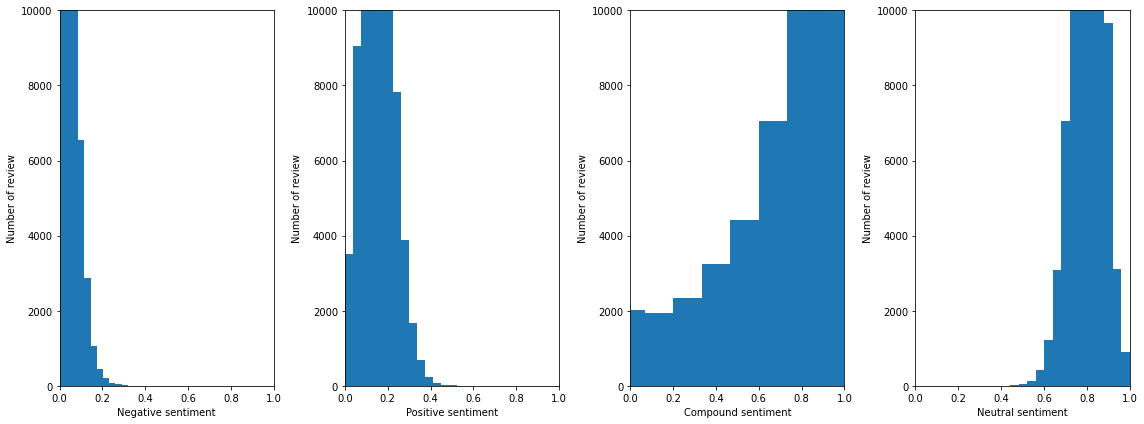

In [16]:
ROW = 10000
df_rev_low.shape

plt.close('all')
fig = plt.figure(figsize=(16,6))

ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_reviews_adv_low.review]
ax1.hist(negative_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment', ylabel = 'Number of review') 

positive_sent = []
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_reviews_adv_low.review]
ax2.hist(positive_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment', ylabel = 'Number of review') 

total_sent = []
[total_sent.append(analyzer.polarity_scores(sent)['compound']) for sent in df_reviews_adv_low.review]
ax3.hist(total_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Compound sentiment', ylabel = 'Number of review') 

neutre_sent = []
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_reviews_adv_low.review]
ax4.hist(neutre_sent,bins=15)
ax4.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment', ylabel = 'Number of review') 

plt.tight_layout()

In [95]:
df_rev_low_sco = df_reviews_adv_low.loc[df_rev_low['location'] == 'Scotland',:]
df_rev_low_wal = df_reviews_adv_low.loc[df_rev_low['location'] == 'Wales',:]
df_rev_low_ir = df_reviews_adv_low.loc[df_rev_low['location'] == 'Northern Ireland',:]

[(0.0, 1.0),
 (0.0, 10000.0),
 Text(0.5, 0, 'Negative sentiment Northern Ireland'),
 Text(0, 0.5, 'Number of review gabon')]

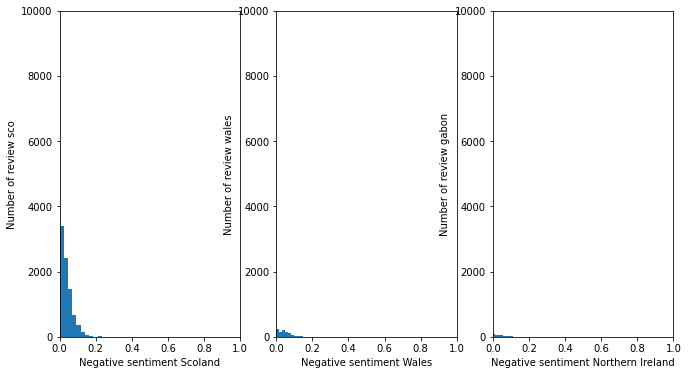

In [99]:
plt.close('all')
fig = plt.figure(figsize=(11,6))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low_sco.review]
ax1.hist(negative_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment Scoland', ylabel = 'Number of review sco') 

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low_wal.review]
ax2.hist(negative_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment Wales', ylabel = 'Number of review wales') 

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low_ir.review]
ax3.hist(negative_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment Northern Ireland', ylabel = 'Number of review gabon') 




[(0.0, 1.0),
 (0.0, 10000.0),
 Text(0.5, 0, 'Positive sentiment Northern Ireland'),
 Text(0, 0.5, 'Number of review Northern Ireland')]

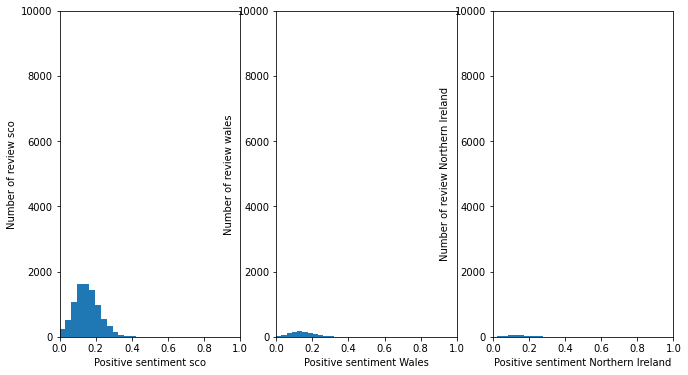

In [101]:
plt.close('all')
fig2 = plt.figure(figsize=(11,6))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

positive_sent = []
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low_sco.review]
ax1.hist(positive_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment sco', ylabel = 'Number of review sco') 

positive_sent=[]
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low_wal.review]
ax2.hist(positive_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment Wales', ylabel = 'Number of review wales') 

positive_sent=[]
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low_ir.review]
ax3.hist(positive_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment Northern Ireland', ylabel = 'Number of review Northern Ireland') 

[(0.0, 1.0),
 (0.0, 10000.0),
 Text(0.5, 0, 'Neutral sentiment Northern Ireland'),
 Text(0, 0.5, 'Number of review Northern Ireland')]

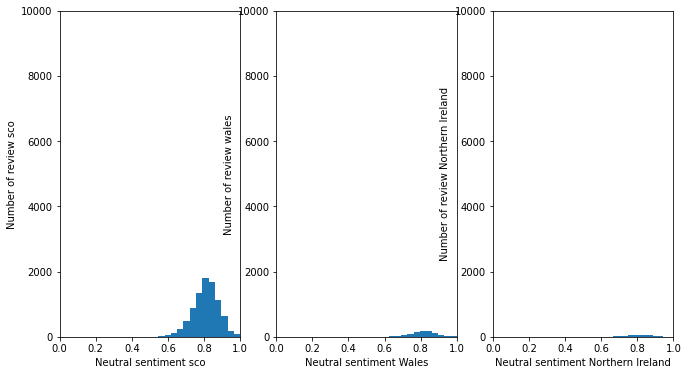

In [105]:
plt.close('all')
fig2 = plt.figure(figsize=(11,6))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

neutre_sent = []
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low_sco.review]
ax1.hist(neutre_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment sco', ylabel = 'Number of review sco') 

neutre_sent=[]
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low_wal.review]
ax2.hist(neutre_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment Wales', ylabel = 'Number of review wales') 

neutre_sent=[]
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low_ir.review]
ax3.hist(neutre_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment Northern Ireland', ylabel = 'Number of review Northern Ireland') 